# Think Bayes: Chapter 5

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from thinkbayes2 import Pmf, Cdf, Suite, Beta
import thinkplot

## Exercises

**Exercise:**  Suppose you are having a dinner party with 10 guests and 4 of them are allergic to cats.  Because you have cats, you expect 50% of the allergic guests to sneeze during dinner.  At the same time, you expect 10% of the non-allergic guests to sneeze.  What is the distribution of the total number of guests who sneeze?

** Solution **
So I effectively have two distributions here, which I want to add together: the distributions of the allergic guests, and the distributions of the non-allergic guests.

Here, for each guest, I have a yes-no question to ask (will they sneeze or not?), each with a probability $p$ of a positive outcome.

This can be described by a Binomial distribution.

In [2]:
from thinkbayes2 import MakeBinomialPmf

This has two arguments; the probability p of the event happening, and the number of trials n.

In [3]:
allergic = MakeBinomialPmf(n=4, p=0.5)
not_allergic = MakeBinomialPmf(n=6, p=0.1)

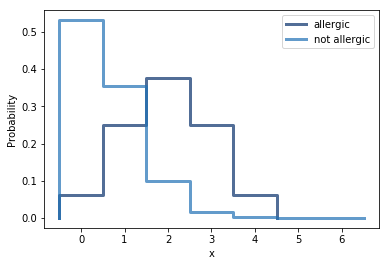

In [4]:
thinkplot.Pmf(allergic, label='allergic')
thinkplot.Pmf(not_allergic, label='not allergic')
thinkplot.Config(xlabel='x', ylabel='Probability')

To capture the overall probability, I can simply add these probability mass functions together.

In [5]:
overall_sneezers = allergic + not_allergic

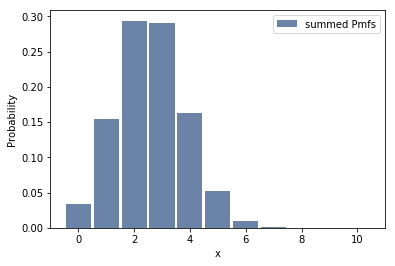

In [6]:
thinkplot.Hist(overall_sneezers, label='summed Pmfs')
thinkplot.Config(xlabel='x', ylabel='Probability')

**Exercise** [This study from 2015](http://onlinelibrary.wiley.com/doi/10.1111/apt.13372/full) showed that many subjects diagnosed with non-celiac gluten sensitivity (NCGS) were not able to distinguish gluten flour from non-gluten flour in a blind challenge.

Here is a description of the study:

>"We studied 35 non-CD subjects (31 females) that were on a gluten-free diet (GFD), in a double-blind challenge study. Participants were randomised to receive either gluten-containing ﬂour or gluten-free ﬂour for 10 days, followed by a 2-week washout period and were then crossed over. The main outcome measure was their ability to identify which ﬂour contained gluten.
>"The gluten-containing ﬂour was correctly identiﬁed by 12 participants (34%)..."
Since 12 out of 35 participants were able to identify the gluten flour, the authors conclude "Double-blind gluten challenge induces symptom recurrence in just one-third of patients fulﬁlling the clinical diagnostic criteria for non-coeliac gluten sensitivity."

This conclusion seems odd to me, because if none of the patients were sensitive to gluten, we would expect some of them to identify the gluten flour by chance.  So the results are consistent with the hypothesis that none of the subjects are actually gluten sensitive.

We can use a Bayesian approach to interpret the results more precisely.  But first we have to make some modeling decisions.

1. Of the 35 subjects, 12 identified the gluten flour based on resumption of symptoms while they were eating it.  Another 17 subjects wrongly identified the gluten-free flour based on their symptoms, and 6 subjects were unable to distinguish.  So each subject gave one of three responses.  To keep things simple I follow the authors of the study and lump together the second two groups; that is, I consider two groups: those who identified the gluten flour and those who did not.

2. I assume (1) people who are actually gluten sensitive have a 95% chance of correctly identifying gluten flour under the challenge conditions, and (2) subjects who are not gluten sensitive have only a 40% chance of identifying the gluten flour by chance (and a 60% chance of either choosing the other flour or failing to distinguish).

Using this model, estimate the number of study participants who are sensitive to gluten.  What is the most likely number?  What is the 95% credible interval?

** Solution ** 
This is similar to the above problem, where I combined the distributions of the guests with allergies and the guests without by combining binomial distributions.

I have 35 hypotheses (each estimating whether 1 - 35 people truly have a gluten sensitivity). In each case, there are two binomial distributions which describe the results; one which describes the results of those who do have a gluten sensitivity, and one which describes the results of those who do not. 

In [30]:
class Sensitive(Suite):
    """Map from a number of sensitive people N to a probability"""
    def __init__(self, hypos):
        """Initialize the distribution.

        hypos: sequence of hypotheses
        """
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, 1)
        self.Normalize()        
        # -1, since one of the hypotheses will be 0
        self.num_participants = len(hypos) - 1
    
    def Likelihood(self, data, hypo):
        """Compute the likelihood of the data under the hypothesis.

        hypo: the number of sensitive people
        data: the number of people who correctly identified gluten
        """
        sensitive = hypo
        not_sensitive = self.num_participants - hypo
        
        # first, generate the binomial distributions for these populations
        sensitive_pmf = MakeBinomialPmf(n=sensitive, p=0.95)
        not_sensitive_pmf = MakeBinomialPmf(n=not_sensitive, p=0.4)
        
        overall = sensitive_pmf + not_sensitive_pmf
        
        # Now, from this distribution find the probability 12 people would have correctly
        # identified the gluten
        return overall.Probs([data])[0]
        

We will actually have 36 hypotheses, since its possible 0 people are gluten sensitive.

In [31]:
gluten = Sensitive(hypos=range(36))

In [32]:
gluten.Update(12)

0.013207615690597462

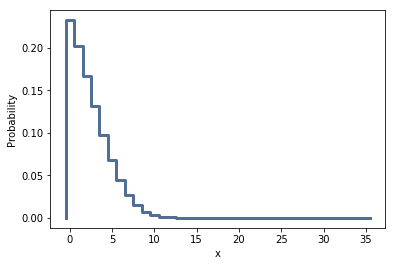

In [33]:
thinkplot.Pmf(gluten)
thinkplot.Config(xlabel='x', ylabel='Probability')

Allowing me to find the most likely number of people with a sensitivity

In [34]:
gluten.Mode()

0

And the 95 % credible interval

In [35]:
gluten.Percentile(5), gluten.Percentile(95)

(0, 7)